# Topic Classification using Naive Bayes
Radhika Mardikar


In [35]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

In [36]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


# Examining the data


In [37]:
def examine(num_examples=5):
    for i in range(num_examples):
      print('Label for message ', i+1, ' is ', newsgroups_train.target_names[train_labels[i]])
      print(train_data[i])
      print()

examine(5)

Label for message  1  is  comp.graphics
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

Label for message  2  is  talk.religion.misc


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil c

# Text representation – transformation

In [38]:
def transform():
    vectorizer1 = CountVectorizer()
    x1 = vectorizer1.fit_transform(train_data)
    print("Part 1")
    print("Size of vocabulary is ", x1.shape[1])
    print("Average number of non-zero features per example ", sum(x1.getnnz(1))/(x1.shape[0]))
    print("Fraction of non-zero entries in the matrix ", sum(x1.getnnz(1))/(x1.shape[0] * x1.shape[1]))
    print("First and last feature names are ", vectorizer1.get_feature_names_out()[0], ' ', vectorizer1.get_feature_names_out()[-1])

    print()
    print("Part 2")
    vectorizer2 = CountVectorizer(vocabulary = ["atheism", "graphics", "space", "religion"])
    x2 = vectorizer2.fit_transform(train_data)
    print("Size of vocabulary is ", x2.shape[1])
    print("Average number of non-zero features per example ", sum(x2.getnnz(1))/(x2.shape[0]))

    print()
    print("Part 3")
    vectorizer3 = CountVectorizer(analyzer = 'char', ngram_range=(2,3))
    x3 = vectorizer3.fit_transform(train_data)
    print("Size of vocabulary is ", x3.shape[1])

    print()
    print("Part 4")
    vectorizer4 = CountVectorizer(min_df = 10)
    x4 = vectorizer4.fit_transform(train_data)
    print("Size of vocabulary is ", x4.shape[1])

    print()
    print("Part 5")
    vectorizer5 = CountVectorizer()
    vectorizer6 = CountVectorizer()
    x5 = vectorizer5.fit_transform(train_data)
    x6 = vectorizer6.fit_transform(dev_data)
    dev_features = vectorizer6.get_feature_names_out()
    train_features = vectorizer5.get_feature_names_out()
    
    count = 0
    for i in dev_features:
      if i not in train_features:
        count += 1
    
    print("Fraction of words in dev vocab but not in train vocab is ", count/len(dev_features))
    

transform()

Part 1
Size of vocabulary is  26879
Average number of non-zero features per example  96.70599803343165
Fraction of non-zero entries in the matrix  0.0035978272269590263
First and last feature names are  00   zyxel

Part 2
Size of vocabulary is  4
Average number of non-zero features per example  0.26843657817109146

Part 3
Size of vocabulary is  35478

Part 4
Size of vocabulary is  3064

Part 5
Fraction of words in dev vocab but not in train vocab is  0.24787640034470024


# Initial model evaluation

In [39]:
def tester():
  vec1 = CountVectorizer()
  train_x = vec1.fit_transform(train_data)
  dev_x = vec1.transform(dev_data)
  
  #kNN model building
  k = [1, 3, 5, 7, 9, 11, 13, 15]
  for i in k:
    model = KNeighborsClassifier(n_neighbors = i)
    model.fit(train_x, train_labels)
    print(i, ' Neighbors model has an F1 score of ', metrics.f1_score(dev_labels, model.predict(dev_x), average='weighted'))
  
  print("Most optimized k value with regards to F1 score is 7.")
  print()
  
  #Naive Bayes model building
  alphas = [0.000001, 0.00001, 0.001, 0.1, 1, 10, 20]
  for j in alphas:
    model1 = MultinomialNB(alpha = j)
    model1.fit(train_x, train_labels)
    print('Alpha value of ', j,' has an F1 score of ', metrics.f1_score(dev_labels, model1.predict(dev_x), average='weighted'))
  
  print("Most optimized alpha value with regards to F1 score is 0.1")
  print()

  #Logistic Regression model building
  C = [0.001, 0.01, 0.1, 1, 10, 100]
  for k in C:
    model2 = LogisticRegression(C=k, solver = 'liblinear', multi_class = 'auto')
    model2.fit(train_x, train_labels)
    print('L2 regularization strength value of ', k,' has an F1 score of ', metrics.f1_score(dev_labels, model2.predict(dev_x), average='weighted'))
    squarelist = []
    for i in range((model2.coef_).shape[0]):
      summ = sum(model2.coef_[:,i] **2)
      squarelist.append(summ)

    print('Sum of squared weights for each topic ', squarelist)
  

tester()

1  Neighbors model has an F1 score of  0.3805030018531525
3  Neighbors model has an F1 score of  0.4084150225437623
5  Neighbors model has an F1 score of  0.4287607236218357
7  Neighbors model has an F1 score of  0.45047910006117586
9  Neighbors model has an F1 score of  0.4365666176198027
11  Neighbors model has an F1 score of  0.4266108018696209
13  Neighbors model has an F1 score of  0.42404338833763805
15  Neighbors model has an F1 score of  0.4326339805547054
Most optimized k value with regards to F1 score is 7.

Alpha value of  1e-06  has an F1 score of  0.7515918405181448
Alpha value of  1e-05  has an F1 score of  0.7533492167780379
Alpha value of  0.001  has an F1 score of  0.7702518836155706
Alpha value of  0.1  has an F1 score of  0.7903052385098862
Alpha value of  1  has an F1 score of  0.7777320236017224
Alpha value of  10  has an F1 score of  0.6674814338256576
Alpha value of  20  has an F1 score of  0.6344096294200738
Most optimized alpha value with regards to F1 score is

1. K-nearest neighbors doesn't work too well here because there is very high dimensionality (too many features). Additionally, the distance metric doesn't really make sense for this type of problem, we'd probably have to experiment with a different distance evaluation metric. 
2. Having a larger feature set helps to fit more of the Naive Bayes criteria (independence between features) so that's why Naive Bayes is outperforming Logistic Regression in this case. If we had a larger sample set, we should expect to see better performance from the logistic models.
3. The C value is the inverse of the regularization parameter so it should be positively correlated with the sum of squared weights. This means that a higher C score would mean a lower penalty and therefore a higher sum of squared weights.

# Feature exploration

In [40]:
def explorer():
    vec = CountVectorizer(ngram_range=(2,2))
    xtrain = vec.fit_transform(train_data)
    logreg = LogisticRegression(C=0.5, solver='liblinear', multi_class='auto')
    logreg.fit(xtrain, train_labels)
    words = vec.get_feature_names_out()

    #finding features with largest weight by topic
    table = np.zeros((4,5), dtype=object)
    indexlist = []
    for i in range(len(newsgroups_train.target_names)):
      print(newsgroups_train.target_names[i])
      values = logreg.coef_[i,]
      values = np.argsort(values)
      sortedvalues = values[-5:][::-1]
      indexlist.append(sortedvalues)
      for j in range(len(sortedvalues)):
        table[i,j] = words[sortedvalues[j]]
      print(table[i,:]) 
    
    print()
    #finding weight for each feature in each topic
    indexlistflat = [index for smalllist in indexlist for index in smalllist]
    features = table.flatten()
    weights = np.zeros((features.shape[0]+1, 5), dtype=object)

    for i in range(len(features)):
      weights[i+1, 0] = features[i]
    for j in range(4):
      weights[0, j+1] = newsgroups_train.target_names[j]
    
    for k in range(len(features)):
      for l in range(len(newsgroups_train.target_names)):
        weights[k+1, l+1] = logreg.coef_[l, indexlistflat[k]]
      
    print("Table for weights of selected features across all topics")   
    df = pd.DataFrame(weights)
    print(df.head(30))

explorer()

alt.atheism
['claim that' 'cheers kent' 'was just' 'you are' 'are you']
comp.graphics
['looking for' 'in advance' 'comp graphics' 'out there' 'is there']
sci.space
['the space' 'the moon' 'sci space' 'and such' 'it was']
talk.religion.misc
['the fbi' 'cheers kent' 'ignorance is' 'but he' 'of jesus']

Table for weights of selected features across all topics
                0            1              2          3                   4
0               0  alt.atheism  comp.graphics  sci.space  talk.religion.misc
1      claim that     0.605549      -0.199067  -0.274345           -0.140364
2     cheers kent      0.55572      -0.697918  -0.663766            0.534808
3        was just      0.48205      -0.131418  -0.128882           -0.227469
4         you are      0.47274      -0.279894  -0.481305            0.028373
5         are you     0.446953      -0.248257  -0.097135           -0.305625
6     looking for    -0.630341       1.108375   -0.50005           -0.571869
7      in advance    -0.4

What's interesting here is some of the features with heavy weights in the alt.altheism topic also had some positive weights in the talk.religion.misc. The feature "cheers kent" is quite popular in particular, and likely requires some more digging as to figuring out context/underlying data. It is interesting that "the fbi" is so popular in the talk.religion.misc topic.

# Pre-processing for text – try to make performance better

In [42]:
def preprocess():

  #Initial logreg model
  vec1 = CountVectorizer(lowercase = False)
  xtrain1 = vec1.fit_transform(train_data)
  devdata1 = vec1.transform(dev_data)
  logreg1 = LogisticRegression(C=0.5, solver='liblinear', multi_class='auto')
  logreg1.fit(xtrain1, train_labels)
  pred = logreg1.predict(devdata1)
  f1score = metrics.f1_score(dev_labels, pred, average = 'weighted')
  print("Vocabulary size without processing is ", len(vec1.get_feature_names_out()))
  print("F1 score is ", f1score)

  #Improved logreg model
  
  train_data1 = train_data.copy()
  train_data1 = punc_remover(train_data1)
  vec2 = CountVectorizer(strip_accents = 'ascii', stop_words = 'english')
  xtrain2 = vec2.fit_transform(train_data1)
  devdata2 = vec2.transform(dev_data)
  logreg2 = LogisticRegression(C=0.5, solver ='liblinear', multi_class ='auto')
  logreg2.fit(xtrain2, train_labels)
  pred1 = logreg2.predict(devdata2)
  print("Vocabulary size with processing is ", len(vec2.get_feature_names_out()))
  f1scoreimp = metrics.f1_score(dev_labels, pred1, average = 'weighted')
  print("F1 score is ", f1scoreimp)
  print()
  print("Improved the score by ", f1scoreimp - f1score)

def punc_remover(train_data):
  for x in range(len(train_data)):  
    train_data[x] = re.sub("'", "", train_data[x] )
  return train_data

preprocess()

Vocabulary size without processing is  33291
F1 score is  0.7069109185493502
Vocabulary size with processing is  26920
F1 score is  0.7286975609516704

Improved the score by  0.0217866424023202


#  L1 and L2 regularization

L1 regularization strength value of  0.01  has an F1 score of  0.4229857798485922
Vocabulary size is  17
L2 regularization strength value of 0.5 has an F1 score of  0.4678284761184072

L1 regularization strength value of  0.1  has an F1 score of  0.6460189361990095
Vocabulary size is  212
L2 regularization strength value of 0.5 has an F1 score of  0.6959644893832598

L1 regularization strength value of  1  has an F1 score of  0.6992547878197551
Vocabulary size is  1141
L2 regularization strength value of 0.5 has an F1 score of  0.6894886547912301

L1 regularization strength value of  10  has an F1 score of  0.6446410472049926
Vocabulary size is  3368
L2 regularization strength value of 0.5 has an F1 score of  0.709982787162527

L1 regularization strength value of  100  has an F1 score of  0.624737118450447
Vocabulary size is  7692
L2 regularization strength value of 0.5 has an F1 score of  0.7043276696358259

L1 regularization strength value of  1000  has an F1 score of  0.586853580986

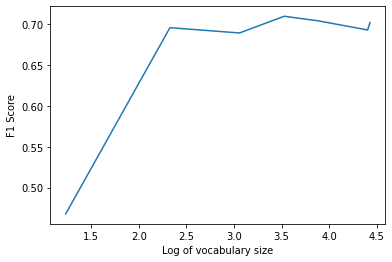

In [8]:
def regularizer():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)
    
    vec1 = CountVectorizer()
    xtrain1 = vec1.fit_transform(train_data)
    xdev1 = vec1.transform(dev_data)

    C = [0.01, 0.1, 1, 10, 100, 1000]
    vocabsize = []
    f1score = []
    indexlist = []
    for k in C:
      model1 = LogisticRegression(C=k, solver = 'liblinear', multi_class = 'auto', penalty = 'l1', tol = 0.015)
      model1.fit(xtrain1, train_labels)
      print('L1 regularization strength value of ', k,' has an F1 score of ', metrics.f1_score(dev_labels, model1.predict(xdev1), average='weighted'))
      indexlist = {}
      vocab = (vec1.get_feature_names_out())
      
      for r in range( len(vocab)):
        indexlist[r] = 0
     
      
      for i in range(model1.coef_.shape[0]):
        for j in range(model1.coef_.shape[1]):
          if model1.coef_[i,j] == 0:
            indexlist[j] += 1
      
      newvocab = []
      for s in range(len(indexlist)):
        if indexlist[s] < 4:
          newvocab.append(s)

      update = vocab[newvocab]
      vocabsize.append(len(update))
      print("Vocabulary size is ", len(update))
      model2 = LogisticRegression(penalty = 'l2', C = 0.5, tol = 0.015, solver="liblinear")
      model2.fit(xtrain1[:, newvocab], train_labels)
      print('L2 regularization strength value of 0.5 has an F1 score of ', metrics.f1_score(dev_labels, model2.predict(xdev1[:,newvocab]), average='weighted'))
      f1score.append(metrics.f1_score(dev_labels, model2.predict(xdev1[:, newvocab]), average='weighted'))

      print()

    
    print("With original full size vocabulary of size ", len(vec1.get_feature_names_out()))
    model3 = LogisticRegression(penalty = 'l2', C = 0.5, tol = 0.015, solver="liblinear")
    model3.fit(xtrain1, train_labels)
    vocabsize.append(len(vec1.get_feature_names_out()))
    print('L2 regularization strength value of 0.5 has an F1 score of ', metrics.f1_score(dev_labels, model3.predict(xdev1), average='weighted'))
    f1score.append(metrics.f1_score(dev_labels, model3.predict(xdev1), average='weighted'))

    plt.plot(np.log10(vocabsize), f1score)
    plt.xlabel('Log of vocabulary size')
    plt.ylabel('F1 Score')
    plt.show()



regularizer()

The reduced vocabulary sizes have around the same performance as the full size vocabulary with L2 regression. It is not significantly better (F1-Score wise) however, it is likely to be computationally less expensive to use a model with fewer features.

# TfIdf

In [43]:
def newvec():
  vec1 = TfidfVectorizer()
  xtrain = vec1.fit_transform(train_data)
  dev = vec1.transform(dev_data)
  
  model = LogisticRegression(C=100, solver='liblinear', multi_class='auto')
  model.fit(xtrain, train_labels)
  
  ypred = model.predict(dev)
  probs = model.predict_proba(dev)
  print('TfIidf F1 score of ', metrics.f1_score(dev_labels, ypred, average='weighted'))
  print()

  rratio = []
  for i in range(dev.shape[0]):
    rratio.append(probs[i, ypred[i]]/probs[i, dev_labels[i]])
  rratio = np.asarray(rratio)
  rratio_small = (np.argsort(rratio))[-3:][::-1]
  
  for j in rratio_small:
    print("Correct label is ", newsgroups_train.target_names[dev_labels[j]])
    print("Predicted label is ", newsgroups_train.target_names[ypred[j]])
    print("R Value is ", rratio[j])
    print("Document: ", dev_data[j])
    print()

newvec()

TfIidf F1 score of  0.7597662427853104

Correct label is  talk.religion.misc
Predicted label is  comp.graphics
R Value is  929.3571373334202
Document:  I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), but may not charge
anything for their time in

1. Count vectorizer counts the number of times a word occurs across all the training examples.
On the other hand Tf-Idf is broken down into two parts. The Tf (term frequency) shows how the count of a word's appearance divided by the total number of words. The Idf (inverse document frequency) takes the log of the number of documents the word has appeared in divided by the total number of documents. 
In essence, the Tf-Idf is kind of like a weighted average for the words and adjusts weights according to how frequently they appear. 

3. The R-ratio shows the model's probability associated with the predicted label divided by the probability associated with the true label. The purpose here is to see the magnitude of discrepancy in terms of how far off the model was in its prediction.

4. Many documents (like the one misclassifed above) use typically computer content associated language in their text. This leads to confusion between the comp.graphics topic and the talk.religion.misc topic. A possible way to mitigate this is to place higher emphasis on the religion based words which may not occur so frequently. This could be done by introducing words to flag.
